In [3]:
# Code to plot the AWG response. 
# Pradip Gatkine (24 Feb 2021)

import numpy as np;
import matplotlib.pyplot as plt
from astropy.io import fits
import math
from scipy.optimize import curve_fit
import glob
import os
import sys
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import linalg
import pprint

import re
plt.rc('font', family='serif')
from matplotlib import rc
import pandas as pd


#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

# Import File

In [4]:
''' Importing the data file here. You can also simply use the name of the 
file here. This assumes that the data file is in the same folder as the
code. If not, please add the relative or full path of the file. This import
statement works in Linux. A different library/statement maybe needed for 
Windows.'''
#print("Current working dir : S%s" % os.getcwd())
File_list = sorted(glob.glob("*.dat"))
for file in range(len(File_list)):
    File_list[file] = os.getcwd() + "\\" + File_list[file]
pprint.pprint(File_list)

['C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Continuous_AWG_Response.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Ph_Err_120.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Ph_Err_240.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Ph_Err_60.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0_edited.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\SiN_Slab_Nguide_none_PhErr_0_inp_str_24ptsscan1.dat']


In [5]:
file_num = 0

df = pd.read_table(File_list[file_num], sep="\s+")
chan_num = df.shape[1] - 1 
# This is the number of channels in the AWG. For higher resolution AWGs, 
#this number will be higher.
a = np.arange(0, chan_num + 1)
a_string = [str(a_i) for a_i in a] 
df = pd.read_table(File_list[file_num], sep="\s+", names=a_string)

if not ((df < 0).any(axis = None)): #Check if the transmission isn't already in dB
    for ind in a_string[1:]:
        df[ind] = 10*np.log10(df[ind]) #Convert to dB
if not ((df['0'] > 10**2).any(axis = None)): 
    #Check if the transmission isn't already in nm       
    df['0'] = 1000*df['0']  #multiplying by 1000 to convert to nm.
#df = df.iloc[28:] 
'''the transmission is weirdly high and constant in the 7th channel between
1518.225000 and 1520.033333 nm'''
channels = np.array(range(1, chan_num + 1))

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1518.22500,-58.52570,-58.0364,-54.67190,-54.25234,-54.41543,-54.11261,-57.26113,-57.05704,-48.62174,...,-48.62174,-48.82917,-57.26110,-57.57875,-54.41543,-54.83527,-54.67177,-55.16005,-58.52578,-58.52578
1,1518.28958,-58.52570,-58.0364,-54.67190,-54.25234,-54.41543,-54.11261,-57.26113,-57.05704,-48.62174,...,-48.62174,-48.82917,-57.26110,-57.57875,-54.41543,-54.83527,-54.67177,-55.16005,-58.52578,-58.52578
2,1518.35417,-58.52570,-58.0364,-54.67190,-54.25234,-54.41543,-54.11261,-57.26113,-57.05704,-48.62174,...,-48.62174,-48.82917,-57.26110,-57.57875,-54.41543,-54.83527,-54.67177,-55.16005,-58.52578,-58.52578
3,1518.41875,-58.52570,-58.0364,-54.67190,-54.25234,-54.41543,-54.11261,-57.26113,-57.05704,-48.62174,...,-48.62174,-48.82917,-57.26110,-57.57875,-54.41543,-54.83527,-54.67177,-55.16005,-58.52578,-58.52578
4,1518.48333,-58.52570,-58.0364,-54.67190,-54.25234,-54.41543,-54.11261,-57.26113,-57.05704,-48.62174,...,-48.62174,-48.82917,-57.26110,-57.57875,-54.41543,-54.83527,-54.67177,-55.16005,-58.52578,-58.52578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1559.81667,-8.01377,-58.0364,-37.50006,-54.25234,-64.89744,-54.11261,-49.47469,-57.05704,-52.35169,...,-54.36032,-48.82917,-53.92876,-57.57875,-55.51082,-54.83527,-47.11087,-55.16005,-23.43892,-58.52578
645,1559.88125,-8.82747,-58.0364,-39.36827,-54.25234,-61.93813,-54.11261,-49.19538,-57.05704,-52.60307,...,-54.82635,-48.82917,-53.34900,-57.57875,-56.71636,-54.83527,-46.81697,-55.16005,-21.58770,-58.52578
646,1559.94583,-9.74522,-58.0364,-41.40659,-54.25234,-60.27813,-54.11261,-49.11115,-57.05704,-52.99787,...,-55.20847,-48.82917,-52.79680,-57.57875,-57.54271,-54.83527,-46.98365,-55.16005,-19.81523,-58.52578
647,1560.01042,-10.76826,-58.0364,-43.03212,-54.25234,-59.85412,-54.11261,-49.25244,-57.05704,-53.52931,...,-55.46620,-48.82917,-52.22205,-57.57875,-58.78059,-54.83527,-47.09414,-55.16005,-18.13665,-58.52578


In [7]:
channels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

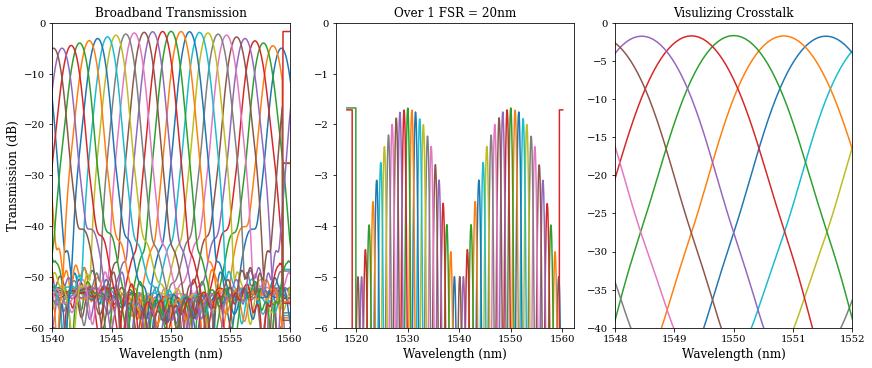

In [8]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))
#plt.plot(range(len(df['0'])), df['0'])
#done defining the Emission_line object!
fig3 = plt.figure(constrained_layout=True, figsize=(12,5))
gs = fig3.add_gridspec(1, 3) #creates grid with one row and 3 columns
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax1.set_title('Broadband Transmission')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('Over 1 FSR = 20nm')
f3_ax3 = fig3.add_subplot(gs[0, 2])
f3_ax3.set_title('Visulizing Crosstalk')
'''
So how do I display a rectangular signal? For a spectral range 
of .1 nanometers, have a constant signal! 
Let's write this very generally so it's easier to adapt for 
more complicated exercises. So for each wavelength range we have
1 dB = 10log_{10}(P/P_0). We want constant source power over a wavelength 
range of 1 angstrom. 
Since we're in the NIR instead of X ray, you don't need to worry about
individual photons as a function of wavelength.
dBm when the reference power is a single milliwatt. dBW is when the 
reference power is a single watt.
'''
#source_signal = [0]*649
stepsize = df.iloc[0,0]-df.iloc[1,0]
df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_ylabel('Transmission (dB)', fontsize=12)
f3_ax1.set_xlim(1518, 1560)
#f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
#plotting!
f3_ax2.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_xlim(1540, 1560)
#f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
#plotting!
f3_ax3.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)

File_in = File_list[file_num]
File_out = File_in[:-4]
plt.savefig(File_out + '.pdf')
plt.show()

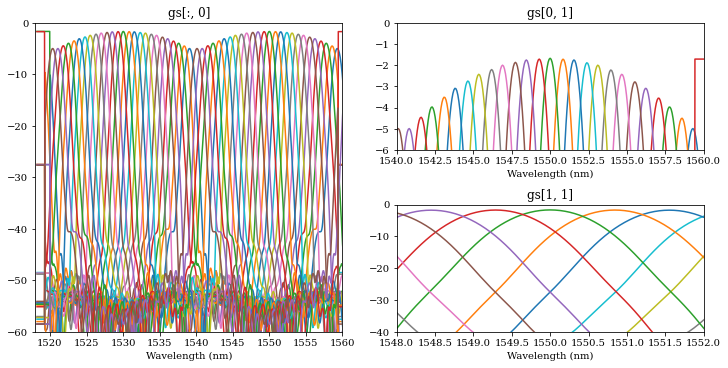

In [9]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))

fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig3.add_gridspec(2, 2)
#What does this mean/do??
f3_ax1 = fig3.add_subplot(gs[:, 0])
f3_ax1.set_title('gs[:, 0]')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('gs[0, 1]')
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax3.set_title('gs[1, 1]')


df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)')
f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
f3_ax2.set_xlabel('Wavelength (nm)')
f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
f3_ax3.set_xlabel('Wavelength (nm)')
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)
plt.show()

## ---------- Upto this part is relevant for Marcos for now ---------------------

# Plot 3-dB width

In [10]:
'''
Reference: 
Peaks: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
Peak widths: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths
'''
# Finding 3-dB width of the AWG peaks.
from scipy.signal import chirp, find_peaks, peak_widths

def find_3dB_width(lam, op_power_norm_fib, FSR):
    d_lam = lam[1]-lam[0]
    FSR_chunk = np.int(0.8*FSR/d_lam) 
    '''
    Taking 80% of the FSR as the minimum distance between the peaks
    Consider the 13th channel. A distance of .8*FSR would use peaks from 
    the next spectral order.
    ''' 
    op_power_norm_fib_lin = np.power(10.0,  op_power_norm_fib/10) 
    # converting to linear scale for peak-width measurement

    peaks, _ = find_peaks(op_power_norm_fib_lin, height = .1, 
                          distance=FSR_chunk)
    '''
    find_peaks is defined in scipy. You can use it to place the emission 
    lines! Get the array from here. 
    '''
    results_half = peak_widths(op_power_norm_fib_lin, peaks, rel_height=0.5)
    # rel_height = 0.5 => FWHM  (half-power beam width)
    #you can define offsets in terms of the FWHM named results_half
    return (peaks, lam[peaks], op_power_norm_fib[peaks], 
            d_lam*results_half[0], d_lam)  # The zeroth element is width

NameError: name 'stringng' is not defined

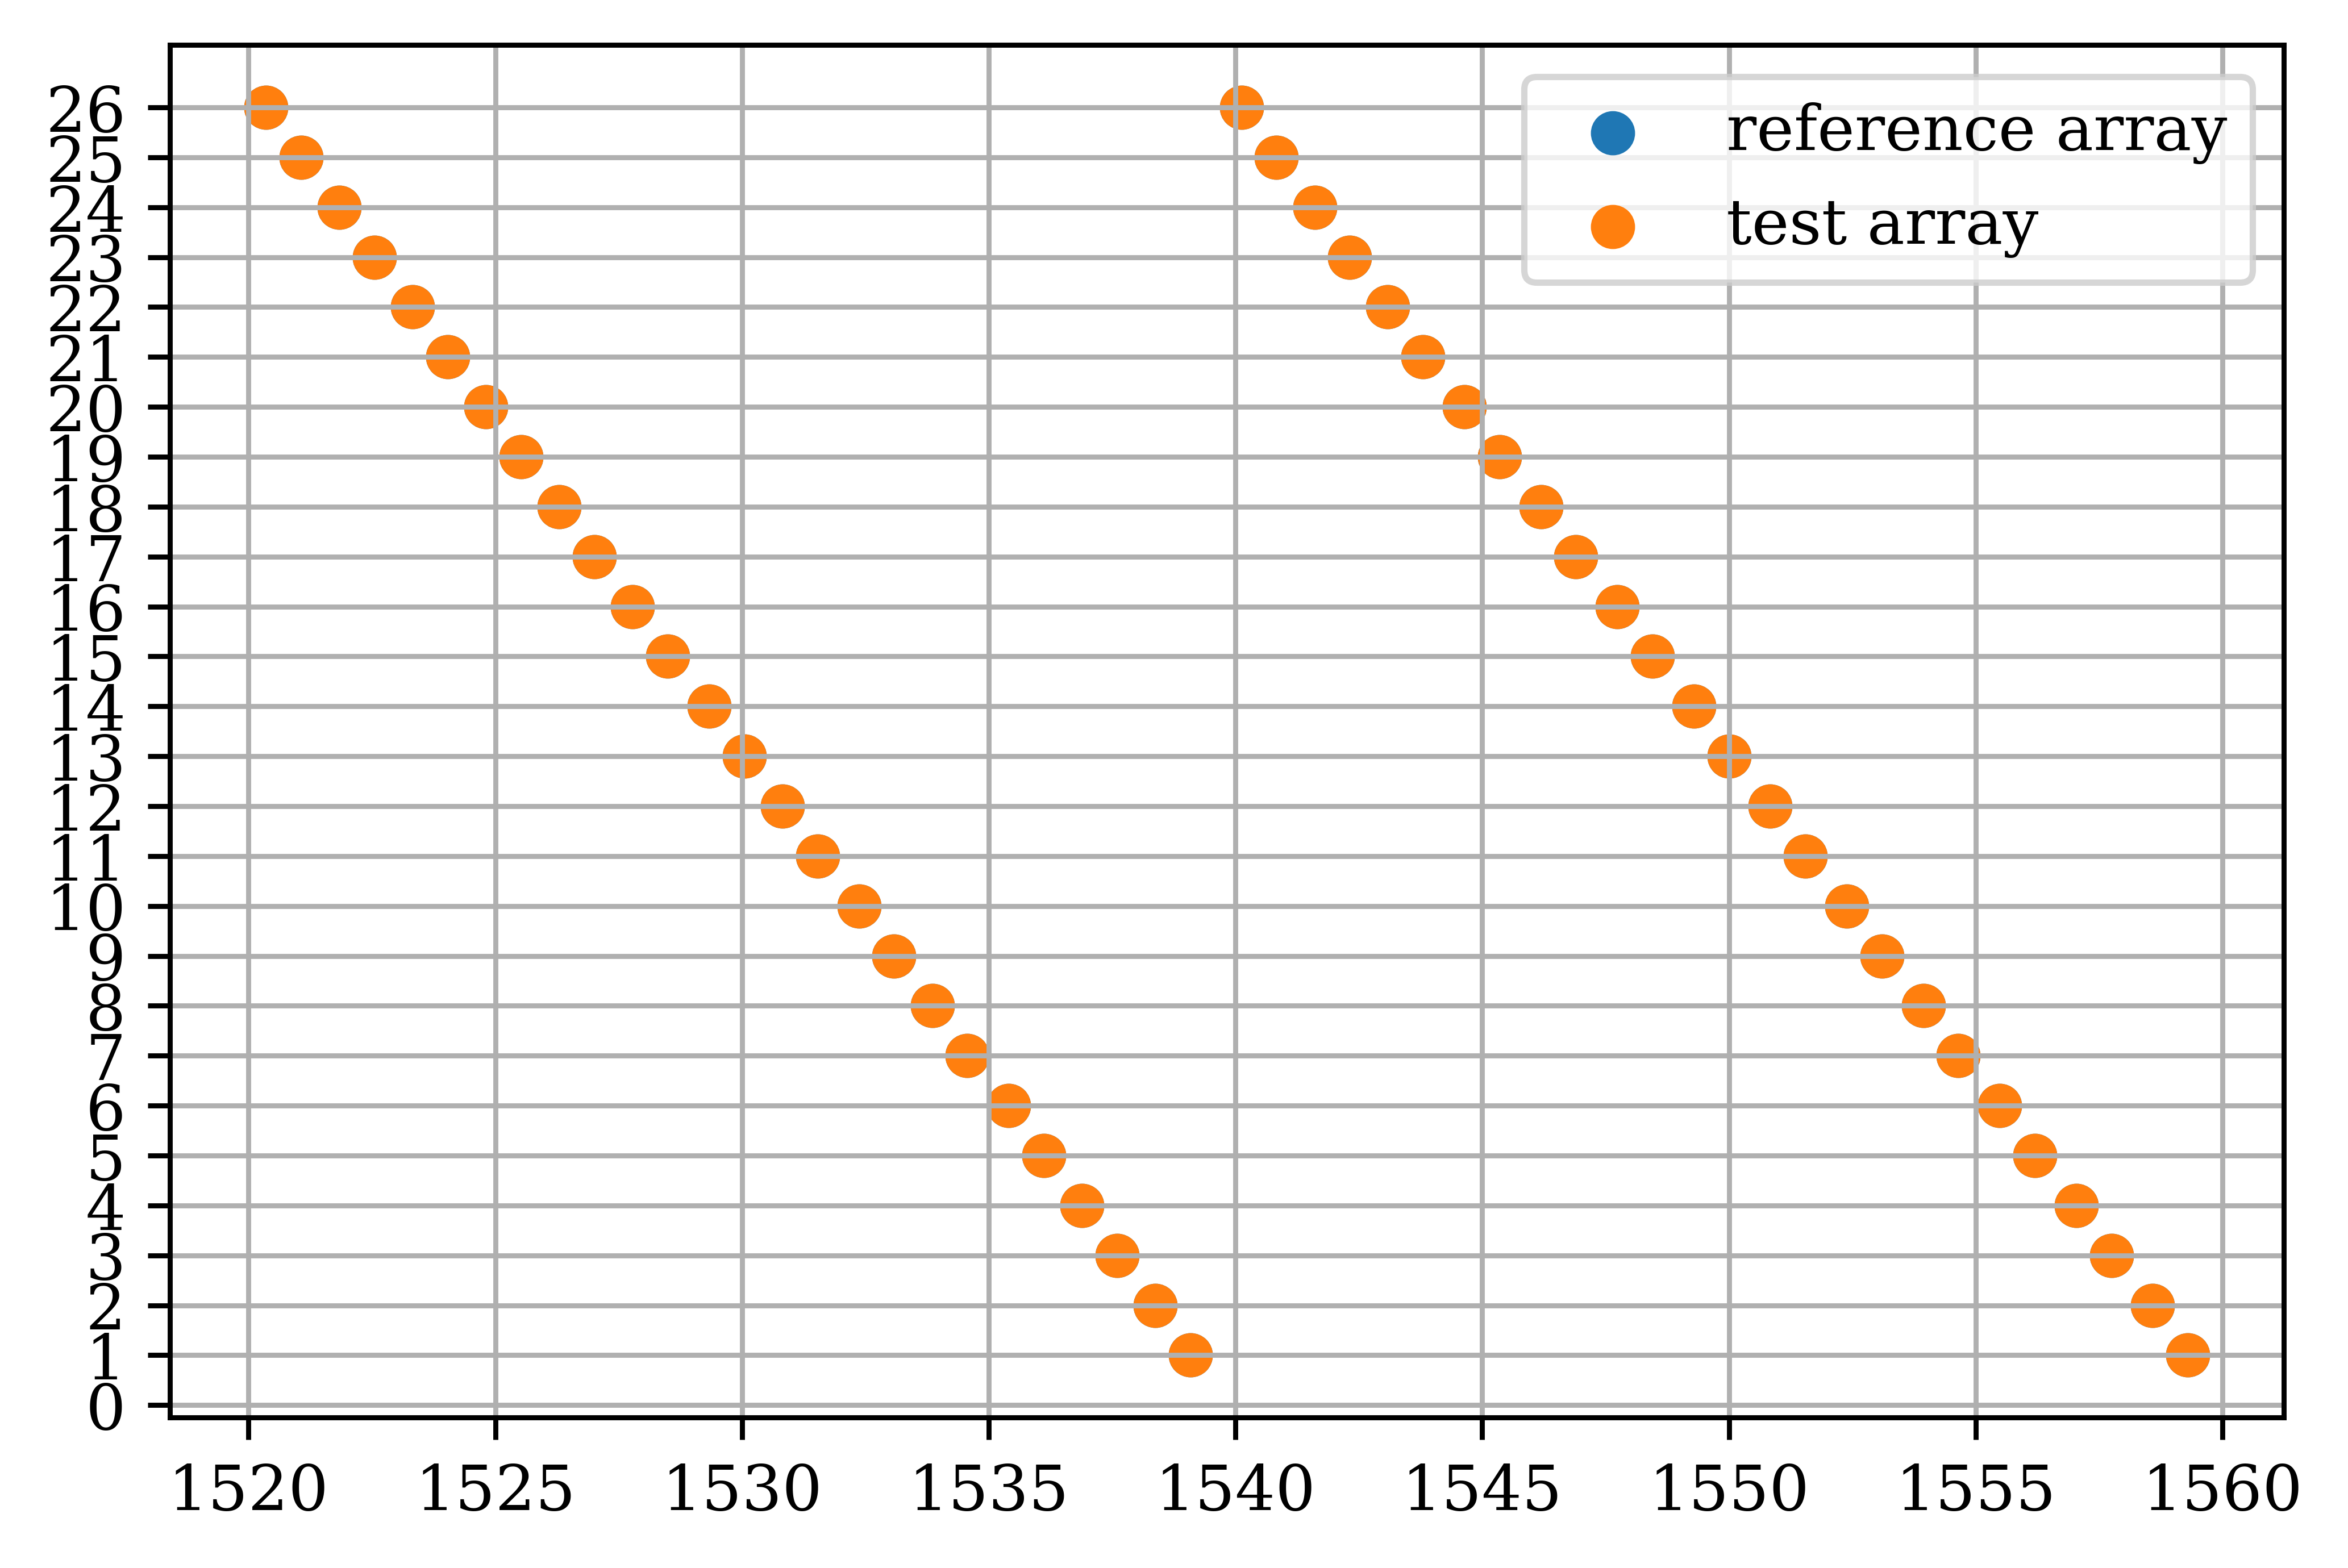

In [11]:
# Marcos Perez being mentored by Pradip Gatkine and Nem Jovanovic (14 June 2021)
'''
The spacing between the peaks of each channel is nonconstant so this 
function will precisely convert a wavelength in nm to its corresponding 
value in channel seperations on the spectrograph. First we will always 
create a dictionary in which each wavelength of peak transmission in each 
channel is a key and its channel is the corresponding value. This dictionary
will be named channel_peaks.
'''
lam = np.array(df['0'])
FSR = 20
channel_peaks = {}
for channel in channels:
    op_power_norm_fib = np.array(df[str(channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    for peak in peaks[1]:
        if(peak > 1520):
            #This filters out the plateaus for shorter wavelengths
            channel_peaks[peak] = channel
channel_peaks_sorted = sorted(channel_peaks.items())
#This sorts the dictionary of peak transmission by wavelength
channel_peaks = {}
for pair in channel_peaks_sorted:
    channel_peaks[pair[0]] = pair[1]
#now we converted the sorted list of pairs into a dictionary for use

'''
The function will use a binary search to find where among the keys in the 
dictionary channel peaks each wavelength in nm corresponds to. The 
corresponding channels will be output as an array named channel_array.
The wavelengths in nm must be entered as an array.
'''

def binary_search(arr, low, high, x):
 
    # Check base case
    if high >= low:
 
        mid = int((high + low) / 2)
 
        # If element is present at the middle itself
        if arr[mid] == x:
            return mid
 
        # If element is smaller than mid, then it can only
        # be present in left subarray
        elif arr[mid] > x:
            return binary_search(arr, low, mid - 1, x)
 
        # Else the element can only be present in right subarray
        else:
            return binary_search(arr, mid + 1, high, x)
 
    else:
        # Element is not present in the array
        return high, low

def convert_nm_to_channels (nm_array, channel_peaks, channel_num , loop):
    channel_array = np.empty(len(nm_array))
    peaks_nm = np.array(list(channel_peaks.keys()))
    for iteration in range(len(nm_array)):
        wavelength = nm_array[iteration]
        peak_index = binary_search(peaks_nm, 0, len(peaks_nm)-1, wavelength)
        '''
        peak_index is the pair of indices corresponding to the transmission
        peaks closest to the desired wavelength
        '''
        if(isinstance(peak_index, list) or type(peak_index) is tuple):
            if (any(np.array(peak_index) < 0)):
                peak_index = (1, 0)
                #This is for wavelengths shorter than any tranmission peak
            if (any(np.array(peak_index) > len(peaks_nm) - 1)):
                peak_index = (len(peaks_nm) - 2, len(peaks_nm) - 1)
                #This is for wavelengths larger than any tranmission peak
            correction = ((wavelength - peaks_nm[peak_index[1]]) / 
            (peaks_nm[peak_index[1]] - peaks_nm[peak_index[0]]))
            correction = abs(correction)
            channel = correction + channel_peaks[peaks_nm[peak_index[1]]]
        else: 
            channel = channel_peaks[peaks_nm[peak_index]]
        if (loop):
            if(channel > channel_num + .5):
                channel = channel % channel_num
        if (channel == 0):
            channel = channel_num
        channel_array[iteration] = channel
    return channel_array

#test_input = np.array(list(channel_peaks.keys())).astype(int)
test_input = np.array(list(channel_peaks.keys()))
plt.figure(dpi = 800)
test = convert_nm_to_channels(test_input, channel_peaks, chan_num, True)  
plt.scatter(np.array(list(channel_peaks.keys())), 
            np.array(list(channel_peaks.values())), 
            label = "reference array")
plt.scatter(test_input, test, label = "test array")
plt.legend()
plt.yticks(ticks = np.arange(chan_num+1))
plt.grid()
string = "If the test input consists only of integers, then" 
string += "(all except maybe the first) the rest of the orange points\n" 
string += "should be between all of the blue points. "
string += "If the test input only includes the transmission peaks,"
stringng += "\nthen only the orange points should be visible"
print(string)

'''
The Gaussian fitting needs a way to accurately convert from channel to nm.
We will do this by creating different dictionary named nm_peaks where the 
keys are the channel and the values are the peak of transmission in nm. 
Here the user will also have to specify which spectral order they are 
referring to. 
'''

In [ ]:
lam

In [ ]:
channel_peaks

In [ ]:
'''
The class calculates what rows in the dataframe are spanned by an emission
line given its shape, width, and height!

I don't assume the center, or boundaries of the emission line fall on the 
exact wavelengths listed in the first column of the dataframe.

The class Emission_line defines the relevant indices in the dataframe given
the center-nanometers and width (or alternatively the left_boundary and 
right_boundary). If its symmetrical, the input for the left_boundary and 
right_boundary will be disregarded. noramlize is a boolean and indicates 
whether or not the area of the emission line should be kept at 1, regardless
of height entered. 

Width is the full width of the emission line, not the half width, nor the 
FWHM. 

So the attributes of the class are: 
self.center_index, self.center_nanometers, self.width_nanometers, 
self.height, self.shape, self.stan_dev_nm, self.symmetrical, 
self.center_index, self.smallest_nanometers, self.largest_nanometers,  
self.smallest_index, self.largest_index, self.width_indices, 
self.row_indices_spanned, self.wavelengths, self.source_power, and 
self.integrated_power. 
It's recommended that  self.row_indices_spanned be used to find the 
relevant rows in the array. self.wavelengths is an array of wavelengths 
in the dataframe spanned by the emission line that correspond to 
self.row_indices_spanned.

For Gaussian emission lines, the standard deviation is taken to be 1/6 of 
the full width of the emission line. Full widths less than twice the 
wavelength increment (here it's approximately 1.5 nm) should be called as 
rectangular emission lines. For Rectangular emission lines, the attribute 
self.stan_dev_nm will be 0 by default. 

To plot the simulated measurement of multiple emission lines, add the 
arrays each named self.integrated_power.
'''
class Emission_line:
   
     #now to find the closest row to the desired center_nanometers
    def __init__(self, center_nanometers, width_nanometers, height, shape,
                 symmetrical, left_boundary, right_boundary, normalize):
        '''
        center_index is the index of the center row of the emission line 
        based on its wavelength, which will be calculated later.
        '''
        self.center_index = 0
        self.shape = shape 
        if (self.shape == "Gaussian" or self.shape == "gaussian"):
                stan_dev = width_nanometers / 6 
                self.stan_dev_nm = stan_dev
                '''
                Needs to have FWHM equal to the full width of a 
                corresponding rectangular profile.
                '''
                width_nanometers = 20
                #This way, the Gaussian will span the entire spectral range
        else:
            self.stan_dev_nm = 0
        self.center_nanometers = center_nanometers
        self.width_nanometers = width_nanometers 
        self.height = height 
        self.symmetrical = symmetrical
        if(not symmetrical and (left_boundary and right_boundary)):
            self.left_boundary = left_boundary
            self.right_boundary = right_boundary
        '''
        Find the what row best corresponds to the wavelength of the center 
        of the emission line.
        '''

        for index in list(range(df.shape[0])):
            if (df.iloc[index,0] == center_nanometers or df.iloc[index,0] > center_nanometers):
                '''
                If there is no wavelength exactly equal to the center we 
                choose the smallest index greater than the desired center. 
                The same will be done for the left boundary 
                (smallest_nanometers) of the emission line. For the right 
                boundary (largest_nanometers) of the emission line, we will
                instead choose the largest wavelength in the dataframe 
                smaller than the right boundary.
                '''
                center_index = index
                break
        try: 
            width_indices  = 1
            smallest_index = 0
            largest_index = df.shape[0]-1
            if(symmetrical):
                self.smallest_nanometers = (
                    center_nanometers - (width_nanometers / 2) )
                self.largest_nanometers = (
                    center_nanometers + (.5*width_nanometers))
            else:
                self.smallest_nanometers = left_boundary
                self.largest_nanometers = right_boundary
            left_range = list(range(0, center_index)) 
            left_range.reverse()
            '''
            left_range is the range within which we'll search for the row 
            with the smallest wavelength. 
            '''
            for index in left_range:
                if (df.iloc[index,0] == self.smallest_nanometers):
                    smallest_index = index
                    break
                elif (df.iloc[index,0] < self.smallest_nanometers):
                    smallest_index = index+1
                    break
            for index in list(range(center_index, df.shape[0])):
                 if (df.iloc[index,0] == self.largest_nanometers):
                    largest_index = index
                    break
                 elif (df.iloc[index,0] > self.largest_nanometers):
                    largest_index = index-1
                    break
            if (largest_index < smallest_index):
                smallest_index, largest_index = largest_index, smallest_index
                '''
                This can happen for < .1 nm emission lines that are exactly
                one of the ones in the row.
                '''
            else :
                width_indices = largest_index-smallest_index+1
            '''
            adding 1 to include the smallest index and to make it match 
            with self.row_indices_spanned. 
            '''
            self.center_index = center_index
            '''
            smallest_index is the index of the highest row of the emission 
            line based on its wavelength.
            '''
            self.smallest_index = smallest_index
            '''
            largest_index is the index of the highest row of the emission 
            line based on its wavelength.
            '''
            self.largest_index = largest_index
            self.width_indices = width_indices
            '''
            now we'll use these indices to define the array
            Source_power is an array of the source signal's power at each 
            wavelength. 
            '''
            source_power = np.empty(self.width_indices)
            #self.row_indices_spanned is a 1 dimensional array
            self.row_indices_spanned = np.array(list(range(smallest_index, 
                                                        largest_index+1)))
            wavelengths = df.iloc[self.row_indices_spanned,0]
            wavelengths = wavelengths.to_numpy() 
            self.wavelengths = wavelengths 
            if (self.shape == "Rectangular" or self.shape == "rectangular"):
                source_power = np.array([self.height]*self.width_indices)
                if (normalize):
                    source_power = source_power/len(self.row_indices_spanned) 
                #This normalizes the emission line for different widths

            elif (self.shape == "Gaussian" or self.shape == "gaussian"):
                source_power = np.array([self.height]*self.width_indices)
                '''
                Here stan_dev is the standard deviation of the Gaussian for
                the emission line.
                Here cont_distr is the continuous distribution of the 
                Gaussian for the emission line.k
                '''
                cont_distr = norm(center_nanometers, stan_dev)
                source_power = cont_distr.pdf(wavelengths)
                if (normalize):
                    area_under_curve = np.trapz(source_power, wavelengths)
                #This normalizes the emission line for different widths
                #This will set the maximum of the array to be 1.   
                    if not (area_under_curve == 0):
                        source_power = source_power/area_under_curve
                        if (any(source_power > 1)):
                            print("Some transmissions will be greater than"+
                                  "1 for a\n" + "normalized Gaussian" +
                                  "emission line of this height and width")
                    else:
                        area_error_message = ("Width of " +
                            str(width_nanometers) + 
                            " is too small for a Gaussian" + 
                            " distribution in this dataframe." +
                          " Please use rectangular shape.")
                        print(area_error_message)
                else:
                    max = np.amax(source_power)
                    source_power = source_power/max
                    
            self.source_power = source_power
            '''
            It's recommended that  self.row_indices_spanned be used to find
            the relevant rows in the array.
            '''
            self.power_transmitted = np.empty(len(self.source_power))
            #We will express everything in arbitary power units
        except (NameError, ValueError):
            error_message = ("Wavelength of " + 
                    str(np.around(center_nanometers, 4)) + " nanometers"
            + " is longer than any wavelength listed in the dataframe\nor "
           + "the emission line has at least one other invalid argument")
            print(error_message)        
            
    def calculate_power_vs_channels(self, channels):   
        '''
        Now let's plot just power vs channel. So we have the transmission 
        in dB, let's convert that to a power in arbitrary power units then 
        sum across each wavelength spanned by each spectral channel in the 
        arrayed waveguide grating (AWG)
        '''
        '''
        In this function, wavelength is an index, not the wavelength in 
        nanometers. Each element in the source_power array corresponds to 
        a different wavelength, hence the name wavelength
        '''
        rows_spanned = self.row_indices_spanned
        try:
            integrated_power = np.empty(len(channels))
            for channel in (channels):
                transmission = df.iloc[rows_spanned, channel]
                transmission = transmission.to_numpy() 
                #necesssary because it can return a pandas.Series instead
                for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0, 
                        (transmission[wavelength] / 10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = (
                        self.power_transmitted[wavelength] * 
                        self.source_power[wavelength])
                integrated_power[channel-1] = self.power_transmitted.sum()
                
        except TypeError: #this should only run if the transmission from a single channel is being simulated
            print("Only channel " + channel + 
                  " is included in the integrated power")
            transmission = df.iloc[rows_spanned, channels]
            transmission = transmission.to_numpy() 
            #necesssary because it can return a pandas.Series instead
            for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0,
                        (transmission[wavelength]/10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = (
            self.power_transmitted[wavelength]*self.source_power[wavelength])
            integrated_power = self.power_transmitted.sum()
            '''
            Here we normalize each emission line by making the peak 1 
            (linear scale) rather than making the area 1.
            '''
        max = np.amax(integrated_power)
        #if (max > 1): 
        #    integrated_power = integrated_power/max
        self.integrated_power = integrated_power
        
test = Emission_line(1540, 0.1, 1, "Rectangular", True, 0, 0, False)

In [ ]:
'''
We need to find the peak wavelength of a channel to use as the center 
wavelength for 
the first emission line! We will use the find_peaks() function built into 
scipy and used by Pradip
in the find_3dB_width() function.
Then we will find the appropriate rows by initializing an Emission_line
object. Then call the function I wrote in it named 
calculate_power_transmitted. We will call this function with an array 
including each of the desired channels, then use the attribute named 
self.integrated_power to plot each output!

All of the terms have the same definition as the in the Emission_line class. 
channels is just an array of the number of channels (1 indexed). Remember, 
the 0th column is still the wavelengths, not the transmission in a channel.
plot_dict is a dictionary where the keys are are the plot colors and the 
values are the plot handles. Now each emission line will both be plotted as
a Gaussian and a rectangular emission line.

On the first pass through plot_dict, we plot the rectnagular profile before 
and after transmission through the spectrograph. 
On the second pass, we plot the Gaussian profile before and after 
transmission through the spectrograph. The 0th and 1st keys and values are
used to label and plot the edges of the original rectangular emission line.

The 3dB width, or full width at half maximum (FWHM) for the Gaussian 
emission line will be the same as the full width for the rectangular 
emission line. Additionally, they will both have a peak of 1 on a linear 
scale (so 0 on a log scale). 

We assume there must be an even number of labels in the dictionary named 
plot_dict. 1 for each edge of the rectangular emission line, and 1 each for
the original and transmitted rectangular and Gaussian emissions. 

The arguments xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size,
ytick_size, and point_label_size meant to customize the size of the label 
of the x axis, y axis, subtitle for each plot, the numerical label for the 
tick mark on each of the x and y axes, and the size of the red dots 
representing each point on the scatter plot.
'''
 

def plot_power_vs_channels(center_nanometers, width_nanometers, height, 
    symmetrical, left_boundary, right_boundary, channels, plot_dict, is_dB,
    ax1, xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, 
    ytick_size, point_label_size, marker_size, line_width, normalize):
    colors = list(plot_dict.values())
    handles = list(plot_dict.keys())
    rectangular_width = width_nanometers 
    gaussian_width = 6 * width_nanometers / 2.355 
    '''
    We want the FWHM to be the same as the full width for the Gaussian. 
    Assuming the standard deviation for the Gaussian is 1/6 of the width 
    input for the emission line class.
    '''
    shortest_wavelength_channel = channels[len(channels)-1]
    '''
    this is the channel we'll use to find out where to plot the red vertical 
    line. It will also help plot the original Gaussian and rectangular 
    profiles. 
    '''
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    shortest_wavelength_peak = peaks[1][0]
    for label in list(range(int(len(plot_dict)/3))):
        if label % 2 == 0:
            shape = "Gaussian"
            width_nanometers = gaussian_width
        else:
            shape = "Rectangular"
            width_nanometers = rectangular_width
        emission_line = Emission_line(center_nanometers, width_nanometers,
            height, shape, symmetrical, left_boundary, right_boundary, 
            normalize)
        emission_line.calculate_power_vs_channels(channels)
        source_power = emission_line.source_power
        wavelengths = emission_line.wavelengths
        '''
        channel_x_values is an array of the wavelengths expressed in terms
        of channel number for the original Gaussian and rectangular 
        profiles, not for the simulated transmission!
        '''
        channel_x_values = convert_nm_to_channels(wavelengths, 
            channel_peaks, chan_num, True)
        nm_channel_dict = {}
        for index in range(len(channel_x_values)):
            nm_channel_dict[channel_x_values[index]] = source_power[index]
        nm_channel_dict_sorted = sorted(nm_channel_dict.items())
        '''
        This will sort the dictionary by the keys, and thus sorting the 
        source_power array by the x values as channels.
        '''
        #This will allow correct plotting 
        nm_channel_dict = {}
        for pair in nm_channel_dict_sorted:
             nm_channel_dict[pair[0]] = pair[1]
        channel_x_values = np.array(list(nm_channel_dict.keys()))
        source_power = np.array(list(nm_channel_dict.values()))
        if (shape == "Rectangular" or shape == "rectangular"):
            '''
            we need to find where there's a large gap in x values to see 
            what parts of the original emission line should be plotted
            separately. The last part of the left array will still be called
            index_min_source.s
            '''
            gap_array = np.empty(len(channel_x_values) - 1)
            for index in range(len(channel_x_values) - 1):
                gap_array[index] = channel_x_values[index + 1] - channel_x_values[index]
            index_min_source = np.argmax(np.abs(gap_array))+1
            print(channel_x_values[index_min_source], channel_x_values[index_min_source-1])
        else:
            index_min_source = np.argmin(source_power)
            '''
            We want all values to the left of the minimum source power to be
            plotted separately from those on the right. left_plot and 
            right_plot indicate where each part of the Gaussian should be 
            plotted 
            '''
        left_plot = np.arange(index_min_source)
        right_plot = np.arange(index_min_source, len(source_power))
        integrated_power = emission_line.integrated_power
        if(is_dB):    
            integrated_power = 10 * np.log10(integrated_power)
            source_power = 10 * np.log10(source_power)
        size = marker_size
        linewidth = line_width
        if (shape == "Rectangular"):
            ax1.axvline(x = channel_x_values[0], ymin = 0, 
                ymax = 0.923076923, linestyle='solid', color = colors[0], 
                linewidth = linewidth)
            ax1.axvline(x = channel_x_values[len(channel_x_values)-1], 
                ymin = 0, ymax = 0.923076923, linestyle='solid', 
                color = colors[0], linewidth = linewidth, 
                label = handles[0])
        if (label == 0):
            line_x = convert_nm_to_channels([center_nanometers], 
                channel_peaks, chan_num, True)
            ax1.axvline(x = line_x, ymin = 0, ymax = 0.923076923, 
                linestyle='solid', color = colors[label+1], 
                        linewidth = linewidth, label = handles[label+1])
        
        #now to plot the original gaussian and square profiles
        ax1.plot(channel_x_values[left_plot], source_power[left_plot], 
                 marker=".", linewidth = linewidth,markersize = size, 
                 color = colors[2*label+3], label = handles[2*label+3])
        ax1.plot(channel_x_values[right_plot], source_power[right_plot],
                 marker=".", linewidth = linewidth, markersize=size, 
                 color = colors[2*label+3])
        #plotting the transmission
        ax1.scatter(channels, integrated_power, s = point_label_size,
                color = colors[2*label+2], label = handles[2*label+2]) 

    '''
    The following code exports the plot to the current working directory
    path_title = "\\Simulated_Power_Transmitted_in_Each_Spectral_Channel\\"
    path_sub_title = "Single_Emission_Line"
    png_path = os.getcwd() + path_title + path_sub_title + ".png"
    pdf_path = os.getcwd() + path_title + path_sub_title + ".pdf"
    plt.savefig(png_path)
    plt.savefig(pdf_path)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(0,-60)
    '''
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    if(is_dB):    
        ylabel = 'Power in dB'
        ax1.set_ylim(-60, 5)
        plt.setp(ax1, yticks = np.array((range(-60 , 10, 10))))
    else:
        ylabel = 'Power (arbitrary units)'
        ax1.set_ylim(0 , 1)
        plt.setp(ax1, yticks = np.array((np.linspace(0 , 1, 11))))
    ax1.set_xlim(1, chan_num + .5)
    ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize)
    ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize)
    ax1.tick_params(axis='x', which='major', labelsize= xtick_size)
    ax1.tick_params(axis='y', which='major', labelsize= ytick_size)
    title = "Lines centered at " + str(np.around(center_nanometers, 4)) 
    title += " nm"
    ax1.set_title(title, fontsize = title_fontsize)
    xticks = np.append(np.array((range(1, chan_num, int(chan_num / 10)))),
            (channels[len(channels) - 1]))
    plt.setp(ax1, xticks = xticks)
'''
plot_power_vs_channels(center_nanometers, width_nanometers, height,
shape, symmetrical, left_boundary, right_boundary, channels, plot_dict,
True)
Keep a set of plotting templates, formats and commands in place to 
copy and paste when needed
'''

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
'''
let's plot the response for emission lines centered at the peak of different
channels! We will use emission lines centered at the peak of channels 1, 3, 
5, 7, and 9.
'''

'''
fig.text(0.5, 0.04, 'Channel Number', ha='center', fontsize = 'small')
fig.text(0.04, 0.5, 'Power in dB', va='center', rotation='vertical',
fontsize = 'small')
'''
lam = np.array(df['0'])
FSR = 20
offset = 0.5 * FSR / chan_num 
#shifting the emission line to the right of the peak by this many nanometers

fig = plt.figure(dpi = 1200)
gs = gridspec.GridSpec(2, 2)
#This is so that we can have 7 plots each take up 2 rows 
plt.subplots_adjust(wspace = .55, hspace = .75)
plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
#Now we will make a dictionary to set the colors and labels for everything in
#the plot
labels = 6
plot_handles, plot_colors = [""]*labels, [""]*labels
plot_handles[0] =  "Edge of Original Rectangular Profile" 
plot_colors[0] = 'red'
plot_handles[1] =  "Center of Original Profiles" 
plot_colors[1] = 'grey'
plot_handles[2] = "Transmission from Gaussian Profile" 
plot_colors[2] = 'blue'
plot_handles[3] = "Original Gaussian Emission" 
plot_colors[3] = 'blue' 
plot_handles[4] = 'Transmission from Rectangular Emission'
plot_colors[4] = 'red'
plot_handles[5] = "Original Rectangular Emission" 
plot_colors[5] = 'red'
plot_dict = {}
for i in range(len(plot_colors)):
    plot_dict[plot_handles[i]] = plot_colors[i]
channels_for_plotting = np.array((range(1, chan_num+1, 
                                        math.ceil(chan_num / 7))))
channels_for_plotting = np.array((4,7))
for index in range(len(channels_for_plotting)):
    peak_channel = channels_for_plotting[index]
    plot_num = index
    plot_indices = np.array((int(plot_num/4), plot_num%4))
    '''
    This two element array iterates through the subplot based on which 
    channel we're choosing the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    #plt.setp(ax1, xticks=np.array((range(1, chan_num+1))), 
    #yticks = np.array((range(-60,10,10))))
    xtick_size = 7
    ytick_size = 9
    xlabel_fontsize, ylabel_fontsize, title_fontsize = [10]*3
    point_label_size = 5
    op_power_norm_fib = np.array(df[str(peak_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peaks[1][0]+offset
    width_nanometers = 1
    height = 1
    symmetrical = True
    left_boundary = 0
    right_boundary = 0
    channels = np.array(range(1, chan_num + 1))    
    marker_size = .75
    line_width = 1
    '''There are len(channels) channels but range will only go up to 1 
    before the second argument!'''
    plot_power_vs_channels(center_nanometers, width_nanometers, height, 
        symmetrical, left_boundary, right_boundary, channels, plot_dict, 
        True, ax1, xlabel_fontsize, ylabel_fontsize, title_fontsize, 
        xtick_size, ytick_size, point_label_size, marker_size, line_width,
        False)
    

#The legend will put at the top what was most recently plotted
#for i in list(range(len(plot_dict))):
#ax.lines[-1].set_label()
#handles, labels = ax1.get_legend_handles_labels()
ax1.legend(loc = "right", bbox_to_anchor = (0, -.6), prop={'size': 8})
caption = "Each rectangular profile has a height of " + str(height) 
caption += " and a full width " 
if not (width_nanometers == 1):
    caption += (str(width_nanometers) + " times the average 3dB width of" +
    "each channel. Each " + "\n" + "Gaussian profile has a FWHM " + 
    str(width_nanometers) + " times the ")
else: 
    caption += ("equal to the average 3dB width of each channel." +
    " Each " + "\n" + "Gaussian profile has a FWHM " + "equal to the ")
caption += "average 3dB width of each channel."
title = ('Simulated Power Transmitted in Each Spectral Channel'
    + ' (ratio of line width to channel spacings = '+  
    str(width_nanometers) +')')
'''
Check the 3dB width of the channels in the continuous AWG and correct
this title once you have it.
'''
plt.suptitle(title, x = .25, y = 1, fontsize=10)
                                                                                        
'''
caption = "Figure 1: The simulated power transmitted by the spectrograph after being dispersed by "
caption = caption + "the Arrayed Waveguide Grating (AWG)\n" + "when observing a rectangular"
caption = caption + " emission line with a full width of .1" + " nanometers (nm)."
caption = caption + " Each emission line is centered at " 
if(offset == 0):
    caption = caption + "\n"
else:
    caption = caption + "a\n" + "wavelength "+ str(offset) + " nm longer than " 
caption = caption + "the peak of an odd numbered channel" 
caption = caption + " (channels 1, 3, 5, 7, 9, 11, and 13, respectively)."
'''
file_path = str(File_list[file_num])
if (len(file_path.split("Res1k_TE_")) > 1):
    caption = file_path.split("Res1k_TE_")[1].split(".dat")[0]
    caption = caption.replace("Ph", "Phase").replace("Err", "Error = ")
    caption = caption + " degrees"
else:
    caption = file_path.split("\\")[len(file_path.split("\\")) - 1].split(".dat")[0].split("_Response")[0]
caption = caption.replace("_", " ")
caption = caption + ", offset = " + str(np.around(offset, 4)) + " nm" 
caption = caption + " (" + str(np.around(offset * chan_num / FSR, 4)) + " channel spacings)"
#plt.text(x = -52.5, y = -100, s = caption, fontsize = 9)
plt.show()

In [ ]:
#Now to make a Gaussian fit of the transmission and get the FWHM to measure the resolving power!
'''
How do I make the x axis loop around? I need to center the channel I want to look at but how? 
Taken any channel further than 6 channels away from the chosen channel and move them to the opposite direction!
Check if there are any channels further than int(len(channels)/2) to the right. Move all the ones further than that
length to the left! Visa versa if there are no channels further than that length to the right. 
Make sure to only rearrange the integrated power array!

The function named center_chosen_channel rearranges the array of power transmission so that it is symmetrical
about channel 7. Note that this only works for emission lines centered at the peak wavelength of the channel!!
'''
def center_chosen_channel(chosen, channels, power):
    length = len(channels)
    halfway = int( (len(channels) + 1) / 2)
    #are there too many channels to the left or right? 
    num_far_channels = abs(chosen-halfway)
    #how many channels are too far to the left or right? 
    if any(channels > chosen + halfway) :
        power = power.tolist()
        channels = channels.tolist()
        for i in range(num_far_channels+1):
            far_channel = power[length-1]
            power.pop(length-1)
            power.insert(0, far_channel)
            channels.pop(length-1)
            channels.insert(0, i+halfway)
        power = np.array(power)
        channels = np.array(channels)

    elif(any(channels < chosen - halfway)):
        power = power.tolist()
        channels = channels.tolist()
        for i in range(num_far_channels+1):
            far_channel = power[length-1]
            power.pop(0)
            power.append(far_channel)
            channels.pop(0)
            channels.append(i+1)
        power = np.array(power)
        channels = np.array(channels)
        
    return (power, channels)

def re_sort_by_channels(rearranged_power, rearranged_channels):
    #put the channels and their transmission back in their original order to plot them!
    power = np.zeros(len(rearranged_channels))

    for index in range(len(rearranged_channels)):
        channel = int(rearranged_channels[index]) - 1
        power[channel] = rearranged_power[index] 
      #  print(channel, power[channel])
    #print(power)
    return power
    
def gauss(x,  *p):
    a, b, c, d = p
    y = a * np.exp(-np.power((x - b),2.) / (2. * c**2)) + d
    return y

In [ ]:
#Now to make a Gaussian fit of the transmission and get the FWHM to measure the resolving power!
'''
How do I make the x axis loop around? I need to center the channel I want to look at but how? 
Taken any channel further than 6 channels away from the chosen channel and move them to the opposite direction!
Check if there are any channels further than int(len(channels)/2) to the right. Move all the ones further than that
length to the left! Visa versa if there are no channels further than that length to the right. 
Make sure to only rearrange the integrated power array!

The function named center_chosen_channel rearranges the array of power transmission so that it is symmetrical
about channel 7. Note that this only works for emission lines centered at the peak wavelength of the channel!!
'''

def log_norm(x, *p):
    a, b, s, c = p
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
    #https://en.wikipedia.org/wiki/Log-normal_distribution
    y = a / (x * s) * np.exp(-np.power(np.log(x) - b, 2.) / (2. * s**2)) + c 
    return y

normalize = False
height = 1
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(range(1, chan_num + 1))
normalize = False
shape = "Gaussian"
step_size = .2
largest_offset = 2
#different in nanometers betweent the wavelengths used for the center of the emission line in each plot
wavelengths = int((largest_offset  / step_size) + 1)
#num is the number of plots we're making
offset_range = np.linspace(0, largest_offset , wavelengths)
FWHM_array_nm = np.array([0.]*wavelengths) #will be in nm
FWHM_array_channels = np.array([0.]*wavelengths)  #will be in channel widths
statistic_array = np.array([0.]*wavelengths)
'''
offset_range is the array of offsets in nm from the center the starting_channel, 
which is the spectral channel where the emission line in the first plot will be centered
'''
lam = np.array(df['0'])
FSR = 20
starting_channel = int(len(channels) / 2)
channels_for_plotting = np.array((starting_channel))
#cols = int(len(channels_for_plotting)/2)+1
cols = 4
rows = 3
#plt.subplots_adjust(wspace = .75*(cols/4), hspace = .75)
#plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
#for starting_channel in channels_for_plotting: 
#print("current channel is ", starting_channel)
channels = np.array(range(1, chan_num + 1))
xtick_size = 8
ytick_size = 9
xlabel_fontsize, ylabel_fontsize, title_fontsize = [11] * 3
point_label_size = 6
line_width = .7
#This refers to a setting while plotting, NOT the width of the emission line in nm
marker_size = .1
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
#for center_nanometers in wavelengths:
rearrange = False
#keep False when plotting centermost channels
plt.figure(figsize = [int((wavelengths + 2) * 6 / rows), 3 * rows], dpi = 600)
width_nanometers = .33
#This is the width of the emission line in nanometers!
gs = gridspec.GridSpec(rows, cols, wspace=.25, hspace = .4)
for offset in offset_range:
    op_power_norm_fib = np.array(df[str(starting_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peaks[1][0] - offset
    channels = np.array(range(1, chan_num+1))
    '''
    op_power_norm_fib = np.array(df[str(channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    offset = 0
    center_nanometers = peaks[1][0]+offset
    '''
    plot_num = int((offset/step_size))
    plot_indices = np.array((int(plot_num / cols), plot_num % cols))
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    ax1.set_ylim(-60, 15)
    plt.setp(ax1, xticks=np.array((range(1, chan_num+1))), yticks = np.array((range(-60,10,10))))
    emission_line = Emission_line(center_nanometers, width_nanometers, height, shape, symmetrical, 
                            left_boundary, right_boundary, normalize)
    emission_line.calculate_power_vs_channels(channels)
    source_power = emission_line.source_power
    wavelengths = emission_line.wavelengths
    shortest_wavelength_channel = channels[len(channels)-1]
    #this is the channel we'll use to find out where to plot the red vertical line 
    #it will also help plot the original Gaussian and rectangular profiles
    op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
    peaks_for_x_values = find_3dB_width(lam, op_power_norm_fib, FSR)
    shortest_wavelength_peak = peaks_for_x_values[1][0]
    '''
    channel_x_values is an array of the wavelengths expressed in terms of channel number for
    the original Gaussian and rectangular profiles, not for the simulated transmission!
    '''
    channel_x_values = convert_nm_to_channels(wavelengths, channel_peaks, chan_num, True)
    stan_dev_channels = emission_line.stan_dev_nm * len(channels) / FSR
    dB_power = 10 * np.log10(emission_line.integrated_power)
    source_power = 10 * np.log10(source_power)
    power = emission_line.integrated_power
    if shape == "Rectangular":
        original_label = "Original Rectangular Emission"
        original_color = "green"
    elif shape == "Gaussian":
        original_label = "Original Gaussian Emission"
        original_color = "grey"
    ax1.plot(channel_x_values, source_power, marker=".", linewidth = line_width,
                 markersize = marker_size, color = original_color, label = original_label)
    if (rearrange):
        original_dB_power = dB_power
        dB_power, rearranged_channels = center_chosen_channel(starting_channel, channels, dB_power)
    
    initial_guess = np.array((np.amax(power) - np.amin(power), 
                       *convert_nm_to_channels([center_nanometers], channel_peaks, chan_num, True), 
                       FSR / (len(channels)), np.amin(power)))
    lower_bound = np.array((-np.inf, -np.inf, .5*FSR / (len(channels)) / 2.355, -np.inf))
    upper_bound = np.array((np.inf, np.inf, 10*FSR / (len(channels)) / 2.355, np.inf))
    bounds = (lower_bound, upper_bound)
    try:
        optimized_values, covariance = curve_fit(f = gauss, xdata = channels, ydata = power, 
                                                 p0 = initial_guess, bounds = bounds)
        
        fit_x_values = np.linspace(channels[0], channels[len(channels)-1], 100)
        smooth_fit = 10 * np.log10(gauss(fit_x_values, *optimized_values))
        fitted_transmission = 10 * np.log10(gauss(channels, *optimized_values))
        line_x = convert_nm_to_channels([center_nanometers], channel_peaks, chan_num, True)
        y_max0 = 0.923076923 * 65 / 75
        y_max1, y_max2 = [0.923076923 * 65 / 75 * .995] * 2
        ax1.axvline(x = line_x, ymin = 0, ymax = y_max0, linestyle='solid', 
                    color = "red", linewidth = .7, label = "Center of Emission Line")
        if (shape == "Rectangular"):
                ax1.axvline(x = channel_x_values[0], ymin = 0, ymax = y_max1, linestyle='solid', 
                            color = "green", linewidth = .65)
                ax1.axvline(x = channel_x_values[len(channel_x_values)-1], ymin = 0, ymax = y_max2, 
                            linestyle='solid', color = "green", linewidth = .65, 
                            label = "Edge of Rectangular Emission")
        ax1.scatter(channels, dB_power, label = "Simulated Transmission", s = point_label_size, color = "red")
        if (rearrange):
            sorted_fit = re_sort_by_channels(fitted_transmission, rearranged_channels) 
            ax1.plot(channels, original_dB_power, label = "Simulated Transmission", 
                     markersize = marker_size, linewidth = line_width)
            ax1.plot(fit_x_values, sorted_fit, label = "Gaussian Fit of Simulated Transmission", 
                     markersize = marker_size, linewidth = line_width)
        else:
            ax1.plot(fit_x_values, smooth_fit, label = "Gaussian Fit of Simulated Transmission", 
                    markersize = marker_size, linewidth = line_width)
        #plt.legend(loc = "lower right", bbox_to_anchor=(1.75, .5))
        #plt.scatter(channels, ((fitted_transmission-dB_power)/dB_power)**2)
        xlabel = "Channel " 
        if rearrange:
            if (starting_channel-halfway < 0):
                xlabel = xlabel + "+" + str(abs(starting_channel+ 1 - halfway))
            elif(starting_channel-halfway > 0):
                xlabel = xlabel + "-" + str(starting_channel + 1 - halfway)
        ylabel = "Transmission in dB"
        ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize)
        ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize)
        title = "Line centered at " + str(np.around(center_nanometers, 4)) + " nm"
        ax1.set_title(title, fontsize = title_fontsize)
        plt.setp(ax1, xticks=np.array((range(1, chan_num+1))), yticks = np.array((range(-60, 15, 10))))
        ax1.tick_params(axis='x', which='major', labelsize= xtick_size)
        ax1.tick_params(axis='y', which='major', labelsize= ytick_size)
        lin_power = np.power(10, dB_power/10)
        lin_transmission = np.power(10, fitted_transmission/10)
        #print("Sum (Residuals) :", np.sum(abs((lin_transmission - lin_power))))
        ax1.grid(which='major', color='grey', alpha=0.4)
        ax1.grid(which='minor', color='grey', alpha=0.1)
        ax1.minorticks_on()
        ax1.tick_params(axis='x', which='minor', bottom=False)
        ax1.xaxis.grid(False, which='minor')
        FWHM_channels = optimized_values[2]*2*math.sqrt(2*math.log(2)) #FWHM in channels
        FWHM_nm = convert_channels_to_nm(FWHM_channels )
        #here this conversion is okay because we're just using the average channel spacing
        #Convert FWHM from channel widths to nanometers
        index = int((offset)/step_size)
        FWHM_array_nm[index] = FWHM_nm
        FWHM_array_channels[index] = FWHM_channels
    except:
        print("initial_guess = ", initial_guess, "\nstandard deviation in nm = ",  emission_line.stan_dev_nm)

ax1.legend(loc = "lower center", bbox_to_anchor=(-.15, -1.5), prop={'size': 6.2*2.5})
ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]+1])
title = "Resolving Power of Photonic Spectrograph"
ax1.set_title(title, fontsize = title_fontsize)
ax1.scatter(offset_range + starting_channel, 
            FWHM_array_nm, color = "green", s = point_label_size)
average_FWHM_nm = np.polyfit(offset_range * len(channels) / FSR + starting_channel, FWHM_array_nm, 0)
count = 3
channel_per_nm = len(channels) / FSR
fit_x_values = np.linspace(offset_range[0] * channel_per_nm + starting_channel, 
                            offset_range[len(offset_range) - 1] * channel_per_nm + starting_channel, 100)
average_FWHM_nm = np.array([average_FWHM_nm]*len(fit_x_values))
ax1.plot(fit_x_values, average_FWHM_nm, label = "Average FWHM, y = " + 
         str(np.around(*average_FWHM_nm[0], 4)) + ' nm')
ax1.set_xlabel("Center of Emission Line (Channels)", fontsize = xlabel_fontsize)
ax1.set_ylabel("FWHM of Gaussian Fit (nm)", fontsize = ylabel_fontsize)
ax1.grid(which='major', color='grey', alpha=0.4)
ax1.grid(which='minor', color='grey', alpha=0.1)
ax1.minorticks_on()
ax1.legend(loc = "lower center", bbox_to_anchor=(.5, -1), prop={'size': 6.2*2.5})
title = 'Simulated Power Transmitted in Each Spectral Channel'
title = title + "\nInput Emisison-line FWHM = " + str(width_nanometers) + r' $\times$' + " channel FWHM"
ax2 = ax1.twinx()
ax2.set_ylabel("Gaussian Fit FWHM (full channel widths)")
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn * len(channels) / FSR, mx * len(channels) / FSR)
ax2.minorticks_on()
file_path = str(File_list[file_num])
if (len(file_path.split("Res1k_TE_")) > 1):
    caption = file_path.split("Res1k_TE_")[1].split(".dat")[0]
    caption = caption.replace("Ph", "Phase").replace("Err", "Error")
else:
    caption = file_path.split("\\")[len(file_path.split("\\")) - 1].split(".dat")[0].split("_Response")[0]
caption = caption.replace("_", " ")
title = title + ", " + caption
plt.suptitle(title, x = .5, y = .99, fontsize = 20)

In [ ]:
'''
Now to make a Gaussian fit of the transmission and get the FWHM to measure 
the resolving power! No plotting but still finding the average FWHM of the 
Gaussian fit for each of the different line widths.
'''
normalize = False
height = 1
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(range(1, chan_num+1))
normalize = False
shape = "Gaussian"
step_size = .3
largest_offset = 3
'''
Different in nanometers between the wavelengths used for the center of the
emission line in each plot.
'''
wavelengths = int((largest_offset  / step_size)+1)
#num is the number of plots we're making
offset_range = np.linspace(0, largest_offset , wavelengths)
FWHM_array_nm = np.array([0.]*wavelengths) #will be in nm
FWHM_array_channels = np.array([0.]*wavelengths)  
#will be in channel widths
statistic_array = np.array([0.]*wavelengths)
'''
offset_range is the array of offsets in nm from the center the 
starting_channel, which is the spectral channel where the emission line in 
the first plot will be centered.
'''
lam = np.array(df['0'])
FSR = 20
channels_for_plotting = np.array((12))
#cols = int(len(channels_for_plotting)/2)+1
starting_channel = 12 #Channel 6 isn't in the same location as it used to be!
channels = np.array(range(1, chan_num+1))
'''
This refers to a setting while plotting, NOT the width of the emission line 
in nm.
'''
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
#for center_nanometers in wavelengths:
rearrange = False
errors = 0
#keep False when plotting centermost channels
widths = np.linspace(.33, 8, 200)
FWHM_average_array = np.empty(shape = (2 , len(widths)))
optimized_value_array = np.empty(shape = (len(widths), 4))
for iteration in list(range(len(widths))):
    width_nanometers = widths[iteration]
    #This is the width of the emission line in nanometers!
    for offset in offset_range:
        center_nanometers = peaks[1][0] - offset
        channels = np.array(range(1, chan_num+1))
        emission_line = Emission_line(center_nanometers, width_nanometers,
            height, shape, symmetrical, left_boundary, right_boundary, 
            normalize)
        emission_line.calculate_power_vs_channels(channels)
        source_power = emission_line.source_power
        wavelengths = emission_line.wavelengths
        '''
        channel_x_values is an array of the wavelengths expressed in terms
        of channel number for the original Gaussian and rectangular 
        profiles, not for the simulated transmission!
        '''
        channel_x_values = convert_nm_to_channels(wavelengths, 
            channel_peaks, chan_num, True)
        stan_dev_channels = emission_line.stan_dev_nm * len(channels) / FSR
        dB_power = 10 * np.log10(emission_line.integrated_power)
        source_power = 10 * np.log10(source_power)
        power = emission_line.integrated_power
        if (rearrange):
            original_dB_power = dB_power
            dB_power, rearranged_channels = center_chosen_channel(
                starting_channel, channels, dB_power)
        
        initial_guess = np.array((
            np.amax(power) - np.amin(power), 
            *convert_nm_to_channels([center_nanometers], channel_peaks, 
            chan_num, True), stan_dev_channels, np.amin(power) ))
        lower_bound = np.array((-np.inf, -np.inf, .1 * stan_dev_channels, 
                                -np.inf))
        upper_bound = np.array((np.inf, np.inf, 10 * stan_dev_channels, 
                                np.inf))
        bounds = (lower_bound, upper_bound)
        try:
            optimized_values, covariance = curve_fit(f = gauss, 
                xdata = channels, ydata = power, p0 = initial_guess, 
                bounds = bounds)
            optimized_value_array[iteration] = optimized_values
            fit_x_values = np.linspace(channels[0], 
                    channels[len(channels)-1], 100)
            smooth_fit = 10 * np.log10(gauss(fit_x_values, 
                    *optimized_values))
            fitted_transmission = 10 * np.log10(gauss(channels,
                *optimized_values))
            
            '''
            print("Maximum (Residuals / Transmission) :", 
            np.amax(abs((fitted_transmission - dB_power)/dB_power)))
            print("Minimum (Residuals / Transmission) :", 
            np.amin(abs((fitted_transmission - dB_power)/dB_power)))
            '''
            FWHM_channels = optimized_values[2]*2*math.sqrt(2*math.log(2))
            #FWHM in channels
            FWHM_nm = FWHM_channels * FSR / len(channels) / 2.355 
            #Convert from FWHM in channel widths to nanometers
            index = int((offset)/step_size)
            FWHM_array_nm[index] = FWHM_nm
            FWHM_array_channels[index] = FWHM_channels
        except:
            print("initial_guess = ", initial_guess, 
                  "\nstandard deviation in nm = ",  
                  emission_line.stan_dev_nm)
            errors = errors + 1 
            if (iteration > 0):
                print(optimized_value_array[iteration - 1])
        
    average_FWHM_nm = np.polyfit(offset_range / ((FSR / len(channels)) + 
        starting_channel, FWHM_array_nm, 0))
    FWHM_average_array[[0] , [iteration]] = width_nanometers
    FWHM_average_array[[1] , [iteration]] = average_FWHM_nm

In [ ]:
errors

In [ ]:
np.savetxt(" Gaussian_Fit_Parameters_Linear_Full_Channel_Widths.csv ", 
           optimized_value_array, delimiter = ",")

In [ ]:
#Plotting the averaged FWHM as a function of line width
channels = np.array(range(1, chan_num+1))
fig, ax1 = plt.subplots()
fig.set_dpi(600)
right_edge_value = 1
left_FWHM = list([])
for col in range(FWHM_average_array.shape[1]):
    current_element = FWHM_average_array[[0] , [col]]
    left_FWHM.append(current_element)
    if (right_edge_value < current_element or right_edge_value == 
        current_element):
        right_edge_index = col
        break
FWHM_x = FWHM_average_array[[0]]
FWHM_y = FWHM_average_array[[1]]
print(FWHM_x[0,0:len(left_FWHM)])
m, b = np.polyfit(FWHM_x[0, 0:len(left_FWHM)], FWHM_y[0, 0:len(left_FWHM)], 
    1)
extended_FWHM_y = m * FWHM_x + b

label = ("Extension of FWHM before slope increase\n y = " + 
str(np.around(m,4)) + "x + " + str(np.around(b, 4)) + " nm")
#now to do a quadratic fit of the whole FWHM
#p1, p2, p3 = np.polyfit(FWHM_x[0], FWHM_y[0], 2)

def quadratic (x, p1, p2, p3):
    y = p1 * (x ** 2) + p2 * x + p3
    return y

#quadratic_fit = quadratic(FWHM_x, p1, p2, p3) 

#do a second linear fit!

right_edge_value = 8
left_edge_index = right_edge_index
right_FWHM = list([])
for col in range(left_edge_index , FWHM_average_array.shape[1]):
    current_element = FWHM_average_array[[0] , [col]]
    right_FWHM.append(current_element)
    if (right_edge_value < current_element or right_edge_value == 
        current_element):
        new_right_edge_index = col
        break
print(FWHM_x[0 , left_edge_index:len(right_FWHM)])
m, b = np.polyfit(FWHM_x[0, left_edge_index:len(right_FWHM)], 
                  FWHM_y[0, left_edge_index:len(right_FWHM)], 1)
new_extended_FWHM_y = m * FWHM_x + b

'''
#This commented out part of the code was used to plot horizontal lines 
representing the average of each 3dB width plt.plot(fit_x_values, 
np.array(([2.2072]*len(fit_x_values))), 
    label = "Ratio of line width to channel 3dB width = 0.50") 
plt.plot(fit_x_values, np.array(([2.1781]*len(fit_x_values))), 
    label = "Ratio of line width to channel 3dB width = 0.33") 
plt.plot(fit_x_values, np.array(([2.346]*len(fit_x_values))), 
    label = "Ratio of line width to channel 3dB width = 1.00")
plt.plot(fit_x_values, np.array(([2.7629]*len(fit_x_values))), 
    label = "Ratio of line width to channel 3dB width = 2.00")
'''
point_label_size = 1
new_label = ("Extension of FWHM after slope increase\n y = " 
             + str(np.around(m,4)) + "x + " + str(np.around(b, 4)) + " nm")
#quad_label = "Quadratic Fit of Averaged FWHM\n y = " + str(np.around(p1,4)) + "x^2 + " + str(np.around(p2,4))
#quad_label = quad_label + "x + " + str(np.around(p3,4)) + "\n"
#ax1.plot(*FWHM_x, *quadratic_fit, '--', color = 'orange', label = quad_label)
ax1.plot(*FWHM_x, *new_extended_FWHM_y, '--', color = 'grey', label = new_label)
ax1.plot(*FWHM_x, *extended_FWHM_y, '--', color = 'blue', label = label)
ax1.plot(*FWHM_x, *FWHM_y, color = 'red', label = "Averaged FWHM as a function\nof emission line width")
ax1.set_xlabel("Width of Emission Line (nm)", fontsize = xlabel_fontsize)
ax1.set_ylabel("FWHM of Gaussian Fit (nm)", fontsize = ylabel_fontsize)
ax1.grid(which='major', color='grey', alpha=0.4)
ax1.grid(which='minor', color='grey', alpha=0.1)
ax1.minorticks_on()
ax2 = ax1.twinx()
ax2.set_ylabel(ylabel = "Gaussian Fit FWHM (channel separations)",  labelpad = 15)
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn * len(channels) / FSR, mx * len(channels) / FSR)
plt.minorticks_on()
ax1.legend(loc = "right", bbox_to_anchor=(1.95, .5), prop={'size': 10})
plt.title("Average FWHM for Different Emission Line Widths")

In [ ]:
#CONTINUOUS OFFSET!
#now to increment the center wavelength by .15nm at a time between the centers of channels 6 and 7
#we'll have a for loop that creates an emission line by creating an instance of the Emission_line class
#the red vertical line is the center of the emission line
step_size = .15
#different in nanometers betweent the wavelengths used for the center of the emission line in each plot
num = int((3 / step_size)+1)
#num is the number of plots we're making
offset_range = np.linspace(0, 3, num)
'''
offset_range is the array of offsets in nm from the center the starting_channel, 
which is the spectral channel where the emission line in the first plot will be centered
'''
lam = np.array(df['0'])
FSR = 20
starting_channel = 6
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
center_nanometers = peaks[1][0]
labels = 6
plot_handles, plot_colors = [""]*labels, [""]*labels
plot_handles[0] =  "Edge of Original Rectangular Profile" 
plot_colors[0] = 'green'
plot_handles[1] =  "Center of Original Profiles" 
plot_colors[1] = 'red'
plot_handles[2] = "Transmission from Gaussian Profile" 
plot_colors[2] = 'blue'
plot_handles[3] = "Original Gaussian Emission" 
plot_colors[3] = 'grey' 
plot_handles[4] = 'Transmission from Rectangular Emission'
plot_colors[4] = 'red'
plot_handles[5] = "Original Rectangular Emission" 
plot_colors[5] = 'green'
plot_dict = {}
for i in range(len(plot_colors)):
    plot_dict[plot_handles[i]] = plot_colors[i]
width_nanometers = .5
width = num*5
channels = np.array(range(1, chan_num+1))
rows = 7
plt.figure(figsize = [int(num*6/rows), 5*rows], dpi=600)
gs = gridspec.GridSpec(rows, int(num/rows), wspace=.25, hspace = .25)
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.51, y = 0.9, fontsize=15)
for offset in offset_range:
    #current_num is the current column the graph will be in
    plot_num = int(offset/step_size)
    plot_indices = list((int(plot_num/3), plot_num % 3))
    '''
    This two element array iterates through the subplot based on which channel we're choosing
    the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    xlabel_fontsize, ylabel_fontsize= [12]*2
    title_fontsize = 13
    xtick_size, ytick_size = [10]*2
    point_label_size = 5
    plot_power_vs_channels(center_nanometers-offset, width_nanometers, 1, True, 
                    left_boundary, right_boundary, channels, plot_dict, True, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)

In [ ]:
#Now let's plot the simulated measurement of multiple emission lines!
'''
#For randomly chosen emission lines
lam1 = df.sample() #this will return the row as a nested array
lam2 = df.sample() #Replace this with specific desired spectral lines afterwards
lam1 = lam1.to_numpy()
lam2 = lam2.to_numpy()
lam1 = lam1[0][0] #retrieving the wavelength from the nested array
lam2 = lam2[0][0]
'''
#plt.subplots_adjust(wspace = .55, hspace = 6.0)
lam = np.array(df['0'])
FSR = 20
op_power_norm_fib = np.array(df['4'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam1 = peaks[1][0]
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam2 = peaks[1][1]
op_power_norm_fib = np.array(df['3'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam3 = peaks[1][0]
center_nanometers = np.array((lam1, lam2))
width_nanometers = [1, 1]
height = [1, 1]
shape = ["Gaussian", "Gaussian"]
channels = np.array(range(1, chan_num+1))
left_boundary, right_boundary = [0]*2, [0]*2
symmetrical = [True, True]
is_dB = True
'''
Note that here, channels refers to each channel transmitting light and not necessarily
channels that will have an emission line at their peak wavelength.
Each input to the function must be an arrray
Should I rewrite this so that there's a singular array for each emission line
instead? it would make it easier to call 
'''
plt.figure(figsize = [4, 4], dpi=600)
gs = gridspec.GridSpec(2, 1, hspace=.6)
ax1 = plt.subplot(gs[0,0])
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.5, y = 1, fontsize=11)
labels = 1
def make_plot_dict(center_nanometers, labels):
    plot_handles, plot_colors = [""] * labels, [""] * labels
    plot_handles[0] =  "Line(s) centered at " 
    if not (height[0] == 0):
        plot_handles[0] = plot_handles[0] + str(np.around(center_nanometers[0], 4)) + " nm"
    if (len(center_nanometers) > 2):
        indices = np.array(list(range(len(center_nanometers)-1)))
        indices = indices+1
        for index in indices: 
            if not (height[index] == 0):
                plot_handles[0] = plot_handles[0] + ", "
                if (index == len(center_nanometers)-1):
                    plot_handles[0] = plot_handles[0] + "and "
                plot_handles[0] =  plot_handles[0] + str(np.around(center_nanometers[index], 4)) + " nm"
    else:
        if not (height[1] == 0):
            plot_handles[0] = plot_handles[0] + " and " 
            plot_handles[0] = plot_handles[0] + str(np.around(center_nanometers[1], 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    return plot_dict
plot_dict = make_plot_dict(center_nanometers, labels)
'''
The below two lines can be used to test whether the power between different
emission lines is added correctly by making sure the power transmitted in the 
first spectral channel doubles when both emission lines are centered on its peak
compared to when the second emission line is longer than all of the wavelengths 
in the dataframe. Make sure to set is_dB to False. Note that first_peak_line
must be added as an argument and that it must be called with the plot_multiple_lines
function as well. Then one can verify the addition is valid by checking that each element
the array named total_integrated_power is exactly twice the corresponding element in 
first_peak_line.integrated_power
'''
first_peak_line = Emission_line(peaks[1][0], 2, 1, "Gaussian", True, 0, 0, False)
first_peak_line.calculate_power_vs_channels(list(range(1, chan_num+1)))
'''
The below function named plot_multiple_lines take the centers, widths, heights, 
shapes, and boundaries of multiple emission lines (at least 2) as well as a plot 
to use named ax1 to plot the power transmitted through each spectral channel 
by observing multiple emission lines simultaneously. The power transmitted through
each spectral channel is simulated by using the dataframe provided by Pradip, here
we have named df. An Emission_line object is created and then overwritten for each
emission line entered as an argument to plot_multiple_lines. Befor each Emission_line 
object is overwritten, the power in each channel is added to an array named 
total_integrated_power. Then, if the user chooses based on the Boolean value of 
is_dB (True means use a log scale in decibels and False means use a linear scale in arbitrary
power units), the array named total_integrated_power is converted to decibels (dB). 
Plot_dict is a dictionary of labels used for each emission line as well as the number of 
colors used to plot. Each emission line's transmitted power is summed together and plotted
as a single output, so this dictionary only has a single key and value. Plot_dict will
be used later if multiple observations wanted to be shown on the same plot.

The arguments xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size, and point_label_size
meant to customize the size of the label of the x axis, y axis, subtitle for each plot, the numerical label 
for the tick mark on each of the x and y axes, and the size of the red dots representing each point on the 
scatter plot
'''
def plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, FSR, plot_dict, is_dB, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, normalize):
    total_integrated_power = np.zeros(len(channels))
    for line in range(len(center_nanometers)):
        try: 
            #create each emission line and then add the power transmitted in each channel
            if(height[line] > 0):
                emission_line = Emission_line(center_nanometers[line], width_nanometers[line], 
                height[line], shape[line], symmetrical[line], left_boundary[line], 
                right_boundary[line], normalize)
                #now we can plot a red vertical line for each emission line
                shortest_wavelength_channel = channels[len(channels)-1]
                #this is the channel we'll use to find out where to plot the red vertical line
                lam = np.array(df['0'])
                op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
                peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
                shortest_wavelength_peak = peaks[1][0]
                line_x = shortest_wavelength_channel-(center_nanometers[line]-shortest_wavelength_peak)
                line_x = line_x * len(channels) / FSR
                #line_x = line_x % len(channels) #for emission lines outside of the spectral range
                if(line_x < .5): #for emission lines closer to channel len(channels) than channel 1
                    line_x = line_x + len(channels)
                ax1.axvline(x = line_x, linestyle='dashed', color = 'r', linewidth = 1)
                emission_line.calculate_power_vs_channels(channels)
                total_integrated_power = total_integrated_power + emission_line.integrated_power
        except:
            print("Line number " + str(line+1) + 
                  " (1-indexed where the first line is 1) has at least one invalid argument")
    if(is_dB):    
        total_integrated_power = 10*np.log10(total_integrated_power)
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array((range(-70,10,10))))
        ylabel = 'Power in dB'
    else:
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array(np.linspace(0,100,11)))
        ylabel = 'Power (arbitrary units)'
    colors = list(plot_dict.keys())
    handles = list(plot_dict.values())
    for label in list(range(len(plot_dict))):
        ax1.scatter(channels, total_integrated_power, s = point_label_size, color = str(colors[label])) 
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    for tick in (ax1.xaxis.get_major_ticks() + ax1.yaxis.get_major_ticks()):
                tick.label.set_fontsize(8)
    ax1.grid(which='minor', color='grey', alpha=0.25)    
    ax1.minorticks_on()
    #ax1.grid(which='minor', color='grey', alpha=0.25)
    plt.setp(ax1, xticks=np.array((range(1, chan_num, int(chan_num / 13)))), yticks = np.array((range(-60,10,10))))
    ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize) # 9
    ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize) # 9
    ax1.set_title(handles[0], fontsize = title_fontsize) # 10
    ax1.tick_params(axis='x', which='major', labelsize= xtick_size) # 7
    ax1.tick_params(axis='y', which='major', labelsize= ytick_size) # 7
    ax1.tick_params(axis='x', which='minor', bottom=False)
    ax1.xaxis.grid(False, which='minor')
    
xlabel_fontsize, ylabel_fontsize= [9]*2
title_fontsize = 10
xtick_size, ytick_size = [7]*2
point_label_size = 3

plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, FSR, plot_dict, is_dB, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)
#now let's make a second plot offset by half a channel
center_nanometers = center_nanometers +.7
plot_dict = make_plot_dict(center_nanometers, labels)
ax1 = plt.subplot(gs[1,0])
plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, FSR, plot_dict, is_dB, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)

In [ ]:
print(df.shape[0] / 52)
print((df.iloc[0,0] - df.iloc[df.shape[0] - 1,0]) * 52 / df.shape[0])
#Thus if I make a calibration matrix for each 
#I need to bin up by a factor of about 12-13 (324/len(channels))
#So the wavelength increment would instead be 1.6765793528505448 for each row in the calibration matrix


In [ ]:
#Calculating the calibration matrix
'''
I'll just integrate the transmission around each peak from peak-.7nm to peak+.7nm 
then make that into square matrix, invert it, and then I'll have the calibration matrix.
I think this is equivalent to having an unnormalized emission line span from 
peak-3dBwidth to peak+3dBwidth
Now this codeblock makes the calibration matrix
'''
from numpy.linalg import inv
channels = chan_num-1
total_matrices = int(df.shape[0]/df.shape[1])+1
inverse_matrices = np.empty(total_matrices)
lam = np.array(df['0'])
channel_array = np.array(list(range(channels)))+1
calibration_matrix = pd.DataFrame(data = np.ndarray(shape=(channels, channels), 
                                dtype=float, order='C'), columns = channel_array)
for channel in channel_array:
    op_power_norm_fib = np.array(df[str(channel)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, 
        op_power_norm_fib, FSR)
    emission_line = Emission_line(peak_lam[0], 1.4, 1, "Rectangular", True, 0, 0, False)
    #go back into notes to see choice of emission line here
    emission_line.calculate_power_vs_channels(channel_array)
    calibration_matrix.iloc[channel-1, 0:channels] = emission_line.integrated_power
    calibration_matrix = calibration_matrix.rename(index = {channel-1 : str(np.around(
        peak_lam[0], 4))})
inverted_matrix = linalg.inv(calibration_matrix)

def test_calibration_matrix(center_nanometers, offset):
    emission_line = Emission_line(center_nanometers+offset, .1, 1, "Gaussian", True, 0, 0, False)
    emission_line.calculate_power_vs_channels(channel_array)
    observation_matrix = np.array([emission_line.integrated_power])
    observation_matrix = observation_matrix.T
    #pprint.pprint(observation_matrix)
    retrieved_spectrum = np.matmul(inverted_matrix, observation_matrix)
    retrieved_spectrum = pd.DataFrame(data = retrieved_spectrum, index = calibration_matrix.index)
    source_wavelengths = df.iloc[emission_line.row_indices_spanned,0]
    source_wavelengths = source_wavelengths.to_numpy()
    source_spectrum = pd.DataFrame(data = emission_line.source_power, index = source_wavelengths)
    #pprint.pprint(retrieved_spectrum)
    #pprint.pprint(source_spectrum) 
    #print(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+2)
    #plt.xlim(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+10)
    fig, ax = plt.subplots()
    fig.set_dpi(600)
    ax = plt.gca() #get current axis
    x = retrieved_spectrum.index
    x = np.array(x, dtype = 'float')
    y = retrieved_spectrum.iloc[0:retrieved_spectrum.shape[0]]
    y = y.to_numpy()
    ax.scatter(x, y, label = "Retrieved Spectrum")
    y = source_spectrum.iloc[0:source_spectrum.shape[0]]
    y = y.to_numpy()
    ax.scatter(source_wavelengths, y, label = "Source Spectrum")
    ax.axvline(x = center_nanometers+offset, linestyle='dashed', color = 'r', linewidth = 2)
    ax.set_xlim(xmin = 1520, xmax = 1540)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='both')
    ax.tick_params(axis='y', which='minor')
    ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
    ax.grid(which='major', color='grey', alpha=0.5)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.legend()
    plt.show()

for channel in channel_array:
    offset = 0
    op_power_norm_fib = np.array(df[str(channel)])
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peak_lam[0]
    test_calibration_matrix(peak_lam[0], offset)


'''
for iteration in list(range(2, total_matrices+1)):
    square_matrix = df.iloc[channels*(iteration-1):channels*iteration, 1:channels+1]
    print(square_matrix)
    inverse_matrices[iteration-1] = inv(square_matrix)
    
TODO - get the appropriate elements from the dataframe (loop through by column, get the peaks and 3dB widths), 
then use that to get the rows! 
I can just get the peaks, make an emission line that spans from -7.nm to +.7nm
'''


#All of the rows are identical! weird. Maybe I'll just make square matrices of all of the linearly independent rows?
#In the first column, the transmission changes value 621 times. 


In [ ]:
#End of what Marcos has written for now

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1,chan_num+1):
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(i)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    #plt.plot(lam, op_power_norm_fib)
    #plt.plot(peak_lam, peak_power, 'b*')
    plt.plot(peak_lam, peak_width, '*')
    

    
ax.minorticks_on()
ax.tick_params(axis='y', which='both')
#ax.grid(which='both')
plt.axhline(y=0.3, linestyle='dashed', color = 'b', linewidth = 2)

#ax = plt.gca()
ax.tick_params(axis='y', which='minor')
ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
ax.grid(which='major', color='grey', alpha=0.5)
ax.set_xlabel('Wavelength (nm)', fontsize=12)

plt.xlim(1518, 1560)  
#plt.ylim(0, 0.75)
#this plot doesn't quite look right. Ask Pradip about it.
#It is fine. This was also used for a specotrgraph with higher spectral resolution
plt.show()
#one point for each channel in each spectral order.

# Plot Spectral Dropout as a function of Resolving power

In [ ]:
def get_spectral_dropout(df, probe_channels, FSR, chan_num):
    peak_lam_array = []
    spec_dropout_array = []
    peak_power_array = []
    
    a = np.arange(1, chan_num+1)
    a_string = [str(a_i) for a_i in a] 
    df2 = np.power(10.0, df[a_string]/10.0)
    spectral_sum = np.array(10*np.log10(df2.sum(axis=1)))
    
    for i in probe_channels: #range(1,chan_num+1):  # No need to do this for all the channels, just do it for the central on and edge one
        lam = np.array(df['0'])
        
        op_power_norm_fib = np.array(df[str(i-1)])
        peak_ind_left, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i+1)])
        peak_ind_right, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i)])
        peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        
        
        peak_power = np.max(peak_power)
        peak_ind = np.max(peak_ind)
        peak_ind_left = np.max(peak_ind_left)
        peak_ind_right = np.max(peak_ind_right)
        
        left_ind = np.min([peak_ind_left, peak_ind, peak_ind_right])
        ind = peak_ind
        right_ind = np.max([peak_ind_left, peak_ind, peak_ind_right])
        
        droupout_left = spectral_sum[peak_ind] - np.min(spectral_sum[left_ind:ind]) 
        droupout_right = spectral_sum[peak_ind] - np.min(spectral_sum[ind:right_ind])
        dropout =  0.5*(droupout_left + droupout_right)
        
        
        peak_lam_array.append(np.max(peak_lam)) # Taking max to ensure only one peak_lam is sent for one channel
        spec_dropout_array.append(dropout)
        peak_power_array.append(peak_power)
    
    return np.array(peak_lam_array), np.array(spec_dropout_array), np.array(peak_power_array)
    


In [ ]:
a = np.arange(1, chan_num+1)
a_string = [str(a_i) for a_i in a] 

df2 = np.power(10.0, df[a_string] / 10.0)
spectral_sum = 10*np.log10(df2.sum(axis=1))


fig, ax = plt.subplots(figsize=(15,8))
df.plot(x='0', legend=0, ax = ax)
ax.plot(df['0'], spectral_sum)

ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('Power (dB)', fontsize=14)
ax.set_xlim(1550, 1555)
ax.set_ylim(-10, 0)

plt.show()